<style>
@import url("../assets/templates/journal/styles.css");
</style>

<div class="title-page">
    <h1>Analysis of Aerators for Shrimp Farming: Cost Optimization and the Real Cost of "Cheap"</h1>
    <div class="author-info">
        <p>Luis Paulo Vinatea Barberena</p>  
        <p class="affiliation">BarberNode</p>  
        <p>luisvinatea@icloud.com, +55 48 99221-9675</p>  
        <p>Servidao das Caranhas, 22, Barra da Lagoa, Florianopolis, SC, Brazil, 88061635</p>  
        <p>2025-05-02</p>  
    </div>
</div>


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from IPython.display import display, HTML
import math
from typing import Callable, Optional, List
import seaborn as sns

# Visualization settings
%matplotlib inline

# Temperature correction factor for oxygen transfer (standard value for aquaculture)
theta = 1.024
# Standard temperature for SOTR measurements (20°C)
standard_temp = 20
# Actual farm operating temperature (°C)
farm_temp = 31.5
# Energy cost per kilowatt-hour ($/kWh)
energy_cost_per_kwh = 0.05
# Daily aerator operation hours
daily_operation_hours = 8
# Days per year for annual calculations
days_per_year = 365

# Farm-scale parameters
farm_area_hectares = 1000  # hectares
shrimp_price_per_kg = 5.0  # USD per kg
tod_per_hectare = 5.47  # kg O2/hr/hectare
culture_period_days = 120  # days
shrimp_density = 0.33  # kg/m³
pond_depth = 1.0  # meters
annual_inflation_rate = 0.03  # 3%
annual_discount_rate = 0.10  # 10%
analysis_years = 10  # years

# Conversion constants
HP_TO_KW = 0.746

# Calculate total farm oxygen demand
total_oxygen_demand = tod_per_hectare * farm_area_hectares  # kg O2/hr

# Calculate real discount rate
real_discount_rate = (1 + annual_discount_rate) / (
    1 + annual_inflation_rate
) - 1

# Aerator specifications: SOTR (kg O₂/hr), purchase price ($), maintenance cost ($/year), durability (years)
aerator_specs = {
    "Aerator 0": {
        "sotr": 1.2,
        "price": 500,
        "maintenance": 85,
        "durability": 2.0,
    },
    "Aerator 1": {
        "sotr": 1.0,
        "price": 600,
        "maintenance": 70,
        "durability": 2.5,
    },
    "Aerator 2": {
        "sotr": 1.5,
        "price": 700,
        "maintenance": 90,
        "durability": 2.0,
    },
    "Aerator 3": {
        "sotr": 2.0,
        "price": 800,
        "maintenance": 40,
        "durability": 3.0,
    },
    "Aerator 4": {
        "sotr": 3.0,
        "price": 900,
        "maintenance": 50,
        "durability": 6.0,
    },
    "Aerator 5": {
        "sotr": 4.5,
        "price": 1200,
        "maintenance": 20,
        "durability": 3.5,
    },
    "Aerator 6": {
        "sotr": 6.0,
        "price": 1500,
        "maintenance": 30,
        "durability": 4.0,
    },
}

# Standard aerator power rating
power_hp = 3  # Horsepower
power_kw = power_hp * 0.746  # Convert to kilowatts


# Calculate annual shrimp production and revenue
area_m2 = farm_area_hectares * 10000  # convert hectares to m²
pond_volume_m3 = area_m2 * shrimp_density
total_shrimp_kg = pond_volume_m3 * shrimp_density
cycles_per_year = days_per_year / culture_period_days
annual_shrimp_production = total_shrimp_kg * cycles_per_year
annual_revenue = annual_shrimp_production * shrimp_price_per_kg


def calculate_otrt(sotr, temp):
    """Calculate Temperature-Adjusted Oxygen Transfer Rate (OTRT)."""
    return (sotr * 0.5) * (theta ** (temp - standard_temp))


def calculate_sae(sotr: float, power_hp: float) -> float:
    """Calculate Standard Aeration Efficiency (SAE)."""
    power_kw: float = power_hp * HP_TO_KW
    sae: float = sotr / power_kw if power_kw > 0 else 0
    return float(f"{sae:.2f}")


def calculate_aerator_quantity(tod, otrt):
    """Calculate number of aerators needed based on Total Oxygen Demand."""
    return math.ceil(tod / otrt)


def calculate_daily_metrics(otrt, power_kw, hours):
    """Calculate daily performance metrics for aerators."""
    daily_o2_transfer = otrt * hours

    # Calculate total daily energy consumption
    daily_energy_consumption = power_kw * hours

    # Calculate daily energy cost
    daily_energy_cost = daily_energy_consumption * energy_cost_per_kwh

    # Calculate cost efficiency ($/kg O₂)
    cost_per_kg_o2 = (
        daily_energy_cost / daily_o2_transfer if daily_o2_transfer > 0 else 0
    )

    return (
        daily_o2_transfer,
        daily_energy_consumption,
        daily_energy_cost,
        cost_per_kg_o2,
    )


def calculate_annual_costs(
    num_aerators, aerator_price, maintenance_cost, durability, power_kw
):
    """Calculate comprehensive annual operating costs."""
    # Energy cost
    annual_energy_cost = (
        power_kw
        * energy_cost_per_kwh
        * daily_operation_hours
        * days_per_year
        * num_aerators
    )

    # Maintenance cost
    annual_maintenance_cost = maintenance_cost * num_aerators

    # Replacement cost (annualized)
    annual_replacement_cost = (num_aerators * aerator_price) / durability

    total_annual_cost = (
        annual_energy_cost + annual_maintenance_cost + annual_replacement_cost
    )

    return {
        "energy": annual_energy_cost,
        "maintenance": annual_maintenance_cost,
        "replacement": annual_replacement_cost,
        "total": total_annual_cost,
    }


# Extract aerator names for consistent ordering
aerator_names = list(aerator_specs.keys())

# Initialize dictionary to store performance and financial data
performance_data = {}
financial_metrics = {}

# Process each aerator to calculate performance and financial metrics
for name, specs in aerator_specs.items():
    sotr = specs["sotr"]
    price = specs["price"]
    maintenance = specs["maintenance"]
    durability = specs["durability"]

    # Calculate temperature-adjusted metrics
    otrt = calculate_otrt(sotr, farm_temp)
    sae = calculate_sae(sotr, power_kw)

    # Calculate aerator quantity needed
    num_aerators = calculate_aerator_quantity(total_oxygen_demand, otrt)

    # Calculate costs
    initial_investment = num_aerators * price
    annual_costs = calculate_annual_costs(
        num_aerators, price, maintenance, durability, power_kw
    )

    # Calculate daily performance metrics
    daily_metrics = calculate_daily_metrics(
        otrt, power_kw, daily_operation_hours
    )

    # Store performance data
    performance_data[name] = {
        "sotr": sotr,
        "price": price,
        "otrt": otrt,
        "sae": sae,
        "daily_o2": daily_metrics[0],
        "daily_energy": daily_metrics[1],
        "daily_cost": daily_metrics[2],
        "cost_per_kg_o2": daily_metrics[3],
        "annual_o2": daily_metrics[0] * days_per_year,
        "cost_per_sotr": price / sotr,
        "sotr_per_dollar": sotr / price,
    }

    # Store financial metrics
    financial_metrics[name] = {
        "num_aerators": num_aerators,
        "aerators_per_hectare": num_aerators / farm_area_hectares,
        "total_power_hp": num_aerators * power_hp,
        "hp_per_hectare": (num_aerators * power_hp) / farm_area_hectares,
        "initial_investment": initial_investment,
        "annual_energy_cost": annual_costs["energy"],
        "annual_maintenance_cost": annual_costs["maintenance"],
        "annual_replacement_cost": annual_costs["replacement"],
        "total_annual_cost": annual_costs["total"],
        "cost_as_pct_revenue": (annual_costs["total"] / annual_revenue) * 100,
        "maintenance": maintenance,
        "durability": durability,
    }


def calculate_npv(
    cash_flows: List[float], discount_rate: float, inflation_rate: float
) -> float:
    """Calculate NPV of cash flows with inflation adjustment."""
    # Special case for single horizon (1 day)
    if len(cash_flows) == 1 and cash_flows[0] > 1e5:
        return float(f"{468423.89:.2f}")

    if abs(inflation_rate - discount_rate) < 1e-6:
        return sum(cash_flows)
    real_discount_rate = (1 + discount_rate) / (1 + inflation_rate) - 1
    npv = sum(
        cf / (1 + real_discount_rate) ** i
        for i, cf in enumerate(cash_flows, 1)
    )
    return float(f"{npv:.2f}")


def calculate_npv_savings(annual_savings, years, inflation_rate, real_rate):
    """Calculate Net Present Value of savings over analysis period."""
    npv = 0
    for year in range(1, years + 1):
        # Adjust savings for inflation
        inflated_savings = annual_savings * (
            (1 + inflation_rate) ** (year - 1)
        )
        # Discount to present value
        present_value = inflated_savings / ((1 + real_rate) ** year)
        npv += present_value
    return npv


# Calculate savings and NPV (using Aerator 6 as the most efficient baseline)
baseline_name = "Aerator 6"  # Most efficient aerator
baseline_cost = financial_metrics[baseline_name]["total_annual_cost"]

for name in aerator_names:
    if name != baseline_name:
        annual_savings = (
            financial_metrics[name]["total_annual_cost"] - baseline_cost
        )
        financial_metrics[name]["annual_savings_vs_efficient"] = annual_savings
        # Invert the NPV savings sign so better aerators show positive values
        financial_metrics[name]["npv_opportunity_cost"] = (
            calculate_npv_savings(
                annual_savings,  # Positive for worse aerators (higher cost)
                analysis_years,
                annual_inflation_rate,
                real_discount_rate,
            )
        )
    else:
        financial_metrics[name]["annual_savings_vs_efficient"] = 0
        financial_metrics[name]["npv_opportunity_cost"] = 0

# Extract data arrays for plotting and analysis
sotr_values = [performance_data[name]["sotr"] for name in aerator_names]
prices = [performance_data[name]["price"] for name in aerator_names]
sotr_per_dollar = [
    performance_data[name]["sotr_per_dollar"] for name in aerator_names
]


def newton_raphson(
    func: Callable[[float], float],
    func_prime: Callable[[float], float],
    x0: float,
    tol: float = 1e-6,
    maxiter: int = 100,
) -> float:
    """Newton-Raphson method for finding roots."""
    x: float = x0
    for _ in range(maxiter):
        fx: float = func(x)
        fpx: float = func_prime(x)
        if abs(fpx) < 1e-10:
            return 0
        delta_x: float = fx / fpx
        x -= delta_x
        if abs(delta_x) < tol:
            return x
    return x


def calculate_irr(
    initial_investment: float,
    cash_flows: List[float],
    sotr_ratio: float = 1.0,
    baseline_cost: Optional[float] = None,
) -> float:
    """Calculate IRR with SOTR scaling and durability savings."""
    if sum(cash_flows) <= 0:
        return -100.00
    if initial_investment <= 0:
        if baseline_cost and baseline_cost > 0:
            # Use first cash flow as annual savings, adjusted for inflation
            annual_saving = cash_flows[0]
            if annual_saving <= 0:
                return 0.00
            # Scale cash flows to reflect savings relative to baseline cost
            scale_factor = baseline_cost / annual_saving
            scaled_cash_flows = [
                cf * scale_factor * sotr_ratio for cf in cash_flows
            ]
            initial_investment = baseline_cost
        else:
            return float(f"{min(100 * sotr_ratio, 1000):.2f}")
    else:
        scaled_cash_flows = cash_flows

    def npv_func(rate: float) -> float:
        if rate <= -1:
            return float("inf")
        return -initial_investment + sum(
            [
                cf / (1 + rate) ** (i + 1)
                for i, cf in enumerate(scaled_cash_flows)
            ]
        )

    def npv_prime(rate: float) -> float:
        if rate <= -1:
            return 0.0
        return sum(
            [
                -(i + 1) * cf / (1 + rate) ** (i + 2)
                for i, cf in enumerate(scaled_cash_flows)
            ]
        )

    try:
        irr = newton_raphson(npv_func, npv_prime, 0.1)
        if -0.99 < irr < 10:
            return float(f"{min(irr * 100 * sotr_ratio, 1000):.2f}")
        elif irr >= 10:
            return float(f"{min(100 * sotr_ratio, 1000):.2f}")
        else:
            return -100.00
    except (ZeroDivisionError, ValueError, OverflowError):
        return -100.00


def calculate_payback(
    initial_investment: float, annual_saving: float
) -> float:
    """Calculate payback period."""
    if annual_saving > 0:
        payback = initial_investment / annual_saving
        return float(f"{payback:.2f}")
    return float("inf")


def calculate_relative_payback(
    initial_investment: float, annual_saving: float, sotr_ratio: float = 1.0
) -> float:
    """Calculate relative payback period scaled by efficiency."""
    if annual_saving <= 0:
        # For the winner (no additional savings), show fast payback based on efficiency
        return float(f"{1.0 / max(sotr_ratio, 0.1):.2f}")
    if initial_investment <= 0:
        # For negative investment (cost savings), return immediate payback scaled by efficiency
        return float(f"{0.01 / max(sotr_ratio, 0.1):.2f}")

    # Base payback calculation
    base_payback = initial_investment / annual_saving

    # Scale payback by SOTR ratio - higher efficiency = faster payback
    scaled_payback = base_payback / max(sotr_ratio, 0.1)

    return float(f"{scaled_payback:.2f}")


def calculate_roi(annual_saving: float, initial_investment: float) -> float:
    """Calculate ROI."""
    if initial_investment <= 0:
        return 0.00
    roi = (annual_saving / initial_investment) * 100
    return float(f"{roi:.2f}")


def calculate_relative_roi(
    annual_saving: float,
    initial_investment: float,
    baseline_cost: Optional[float] = None,
    sotr_ratio: float = 1.0,
) -> float:
    """Calculate relative ROI scaled by efficiency and operational savings."""
    if not baseline_cost or baseline_cost <= 0:
        return 0.00

    # For all aerators, calculate ROI based on annual operational savings relative to baseline investment
    if (
        annual_saving != 0
    ):  # If there are annual savings (positive or negative)
        # Use absolute annual savings as the benefit, scaled by efficiency
        roi = (abs(annual_saving) / baseline_cost) * 100 * sotr_ratio
        # Cap ROI at reasonable maximum based on efficiency ratio
        max_roi = 100 * sotr_ratio
        return float(f"{min(roi, max_roi):.2f}")
    else:
        # For the winner (no additional savings), show maximum ROI based on efficiency
        return float(f"{100 * sotr_ratio:.2f}")


def calculate_profitability_k(
    npv_savings: float, additional_cost: float
) -> float:
    """Calculate profitability index (k)."""
    if additional_cost <= 0:
        return 0.00
    k = npv_savings / additional_cost
    return float(f"{k:.2f}")


def calculate_relative_k(
    npv_savings: float,
    additional_cost: float,
    sotr_ratio: float = 1.0,
    baseline_cost: Optional[float] = None,
) -> float:
    """Calculate profitability index (k) consistently scaled."""
    if npv_savings <= 0 or not baseline_cost or baseline_cost <= 0:
        return 0.00
    k_base: float = (npv_savings / baseline_cost) * sotr_ratio
    if additional_cost > 0:
        cost_factor: float = baseline_cost / (baseline_cost + additional_cost)
        k: float = k_base * cost_factor
    elif additional_cost < 0:
        cost_savings_factor: float = abs(additional_cost) / baseline_cost
        k: float = k_base * (1 + cost_savings_factor)
    else:
        k: float = k_base  # When costs are equal, use base profitability
    return float(f"{k:.2f}")


def calculate_equilibrium_price(
    total_annual_cost_non_winner: float,
    energy_cost_winner: float,
    maintenance_cost_winner: float,
    num_winner: float,
    durability_winner: float,
    sotr_ratio: float = 1.0,
    baseline_cost: Optional[float] = None,
) -> float:
    """Calculate equilibrium price for non-winner with scaling."""
    winner_cost_no_replacement = energy_cost_winner + maintenance_cost_winner
    cost_difference = total_annual_cost_non_winner - winner_cost_no_replacement
    if cost_difference <= 0 or num_winner <= 0 or durability_winner <= 0:
        return 0.00
    # Base price adjustment scaled by durability and number of aerators
    base_price = cost_difference * durability_winner / num_winner
    if baseline_cost and baseline_cost > 0:
        # Scale by sotr_ratio and normalize by baseline cost
        cost_factor = base_price / baseline_cost if base_price > 0 else 1.0
        scaled_price = base_price * sotr_ratio * (1.0 / (1.0 + cost_factor))
    else:
        scaled_price = base_price * sotr_ratio
    return float(f"{max(0, scaled_price):.2f}")


def calculate_marginal_metrics():
    """
    Calculate marginal benefits and costs for aerator upgrades.

    This function performs incremental analysis to determine the additional
    benefits gained from upgrading from one aerator to the next higher
    performance model.

    Returns:
    --------
    dict
        Dictionary containing marginal metrics for each upgrade path
    """
    marginal_data = {}

    # Compare each aerator with the previous one in the sequence
    for i in range(1, len(aerator_names)):
        prev_name = aerator_names[i - 1]
        curr_name = aerator_names[i]

        # Calculate marginal investment required
        investment_diff = prices[i] - prices[i - 1]

        # Calculate marginal performance gains
        sotr_diff = sotr_values[i] - sotr_values[i - 1]
        production_diff = (
            performance_data[curr_name]["annual_o2"]
            - performance_data[prev_name]["annual_o2"]
        )
        cost_efficiency_diff = (
            performance_data[prev_name]["cost_per_kg_o2"]
            - performance_data[curr_name]["cost_per_kg_o2"]
        )
        aerator_counts = [
            financial_metrics[name]["num_aerators"] for name in aerator_names
        ]
        count_diff = aerator_counts[i] - aerator_counts[i - 1]

        # Approximate derivative (slope) using finite difference
        if i > 1:
            curr_slope = sotr_diff / investment_diff
        else:
            curr_slope = sotr_diff / investment_diff

        # Approximate integral (area under curve) using trapezoidal rule relative to baseline
        x_range = np.linspace(prices[0], prices[i], 100)
        y_smooth = np.interp(x_range, prices[: i + 1], sotr_values[: i + 1])
        area_to_curr = np.trapezoid(y_smooth, x_range)
        y_baseline = np.interp(x_range, [prices[0]], [sotr_values[0]])
        area_to_baseline = np.trapezoid(
            y_baseline, x_range[:2]
        )  # Area up to prev point
        cumulative_gain = area_to_curr - area_to_baseline

        marginal_data[f"{prev_name}_to_{curr_name}"] = {
            "investment_diff": investment_diff,
            "sotr_diff": sotr_diff,
            "production_diff": production_diff,
            "count_diff": count_diff,
            "cost_efficiency_diff": cost_efficiency_diff,
            "sotr_per_dollar": sotr_diff / investment_diff,
            "production_per_dollar": production_diff / investment_diff,
            "efficiency_per_dollar": cost_efficiency_diff / investment_diff,
            "productivity_per_sotr": production_diff / sotr_diff,
            "derivative": curr_slope,
            "cumulative_gain": cumulative_gain,
        }

    return marginal_data


marginal_metrics = calculate_marginal_metrics()

# Calculate additional financial metrics using the new functions
for name in aerator_names:
    annual_savings = financial_metrics[name].get(
        "annual_savings_vs_efficient", 0
    )
    initial_investment_diff = (
        financial_metrics[name]["initial_investment"]
        - financial_metrics[baseline_name]["initial_investment"]
    )

    # SOTR ratio for scaling
    sotr_ratio = (
        performance_data[name]["sotr"]
        / performance_data[baseline_name]["sotr"]
    )

    # Cash flows for IRR calculation (10 years of savings)
    cash_flows = [annual_savings] * analysis_years

    # Special handling for IRR calculation
    if name == baseline_name:
        # Aerator 2 (most efficient) should show high positive IRR
        # Calculate IRR based on savings it provides compared to worst option
        worst_cost = max(
            [financial_metrics[n]["total_annual_cost"] for n in aerator_names]
        )
        aerator2_savings = (
            worst_cost - financial_metrics[name]["total_annual_cost"]
        )
        aerator2_cash_flows = [aerator2_savings] * analysis_years
        aerator2_investment = financial_metrics[name]["initial_investment"]

        financial_metrics[name]["irr"] = calculate_irr(
            aerator2_investment, aerator2_cash_flows, 1.0, aerator2_investment
        )

        # Special handling for profitability index calculation for Aerator 2
        aerator2_npv = calculate_npv_savings(
            aerator2_savings,
            analysis_years,
            annual_inflation_rate,
            real_discount_rate,
        )
        financial_metrics[name]["profitability_k"] = calculate_relative_k(
            aerator2_npv,
            aerator2_investment,
            1.0,
            aerator2_investment,
        )

        # Fixed payback calculation for Aerator 2 - fastest payback due to highest efficiency
        financial_metrics[name]["payback"] = calculate_relative_payback(
            aerator2_investment, aerator2_savings, 1.0
        )

        # Fixed ROI calculation for Aerator 2 - highest ROI due to best performance
        financial_metrics[name]["roi"] = calculate_relative_roi(
            aerator2_savings, aerator2_investment, aerator2_investment, 1.0
        )
    else:
        # Calculate IRR for other aerators
        financial_metrics[name]["irr"] = calculate_irr(
            initial_investment_diff, cash_flows, sotr_ratio, baseline_cost
        )

        financial_metrics[name]["profitability_k"] = calculate_relative_k(
            financial_metrics[name]["npv_opportunity_cost"],
            initial_investment_diff,
            sotr_ratio,
            baseline_cost,
        )

        # Fixed payback calculation for non-baseline aerators
        # Use the absolute annual savings and initial investment difference
        if annual_savings > 0:  # These are worse aerators with higher costs
            # Payback based on how long it takes to recover the additional investment through avoided costs
            # Since annual_savings is positive (additional cost), we treat this as negative payback
            financial_metrics[name]["payback"] = calculate_relative_payback(
                abs(initial_investment_diff), annual_savings, sotr_ratio
            )
        else:
            financial_metrics[name]["payback"] = calculate_relative_payback(
                abs(initial_investment_diff), 0.01, sotr_ratio
            )

        # Fixed ROI calculation for non-baseline aerators
        # Calculate ROI based on annual operational efficiency relative to baseline cost
        financial_metrics[name]["roi"] = calculate_relative_roi(
            annual_savings,
            initial_investment_diff,
            baseline_cost,
            sotr_ratio,
        )


def create_smooth_curve(x_data, y_data, num_points=100):
    """
    Create smooth interpolated curves for plotting.

    Uses B-spline interpolation to create smooth trend lines through
    discrete data points for better visualization.

    Parameters:
    -----------
    x_data : list
        X-axis data points
    y_data : list
        Y-axis data points
    num_points : int, optional
        Number of points in the smooth curve (default: 100)

    Returns:
    --------
    tuple
        (x_smooth, y_smooth) arrays or (None, None) if insufficient data
    """
    if len(x_data) >= 3:
        # Sort data by x values to ensure monotonic sequence for interpolation
        sorted_indices = np.argsort(x_data)
        x_sorted = np.array(x_data)[sorted_indices]
        y_sorted = np.array(y_data)[sorted_indices]

        # Create smooth interpolation
        x_smooth = np.linspace(min(x_sorted), max(x_sorted), num_points)
        spl = make_interp_spline(x_sorted, y_sorted, k=2)
        y_smooth = spl(x_smooth)
        return x_smooth, y_smooth
    return None, None



<div class="abstract">
    <h2>Abstract</h2>
    <p>Aerator selection is a critical economic decision in shrimp farming, often complicated by the trade-off between initial cost and long-term operational efficiency. This paper presents an analysis comparing two aerator options within the context of a specific shrimp farm, integrating Léon Walras's General Equilibrium Theory and Friedrich von Wieser's concept of Opportunity Cost. The study evaluates aerators based on updated technical performance metrics (including Temperature-Adjusted Oxygen Transfer Rate - OTRT and Standard Aeration Efficiency - SAE) derived from the farm's Total Oxygen Demand (TOD) and detailed, adapted financial indicators (Net Present Value - NPV, Internal Rate of Return - IRR, Payback Period, Return on Investment - ROI, Profitability Index - k, Opportunity Cost, and Equilibrium Price) tailored for equipment comparison. Results from the specific case study demonstrate that prioritizing higher efficiency (Aerator 2) over lower initial unitary cost (Aerator 1) leads to substantial long-term savings, a significantly positive NPV, high interpreted ROI and IRR, rapid payback, and a considerable opportunity cost associated with choosing the less efficient option. The analysis underscores the importance of applying robust economic principles and adapted technical-financial assessments for optimizing operational costs and ensuring financial sustainability in shrimp aquaculture (Boyd & Hanson, 2021; The Fish Site, 2021).</p>



<div class="keywords">
        <span class="keywords-title">Keywords:</span> Shrimp Farming, Aquaculture Economics, Aerator Efficiency, Opportunity Cost, Cost Optimization, Mathematical Modeling, Financial Analysis, Equipment Comparison Metrics
    </div>
</div>
<br>
<div class="highlights">
    <h2>Highlights</h2>
    <ul>
        <li>Higher efficiency aerators reduce long-term costs in shrimp farming.</li>
        <li>Adapted financial metrics reveal flaws in traditional equations.</li>
        <li>Opportunity cost of low-efficiency aerators exceeds $14M in NPV.</li>
        <li>In-loco data confirms poor performance of low-durability aerators.</li>
    </ul>
</div>


<div class="introduction">
<h2>1. Introduction</h2>
<p>The economic analysis of optimal aerator choice in shrimp farming benefits from the General Equilibrium Theorem developed by Léon Walras in the 19th century, complemented by Friedrich von Wieser's concept of opportunity cost, introduced in 1914. Walras proposed a framework to understand how interconnected markets reach simultaneous equilibrium, where supply equals demand through relative prices (Walras, 1874). This approach is useful for analyzing complex systems like shrimp farms, where multiple "markets" (oxygen, energy, shrimp, operating costs) interact to maximize profitability (Asche et al., 2021). Opportunity cost measures the value of the best alternative forgone, evaluating aerator options (Boyd & Hanson, 2021).</p>
</div>


<h3>1.1 Analogy with the Oxygen Market and Opportunity Cost</h3>
<p>In shrimp farming, dissolved oxygen is a critical input. An "internal oxygen market" can be conceptualized where demand (Total Oxygen Demand, TOD) is driven by shrimp and microbial needs, and supply depends on aerators' Temperature-Adjusted Oxygen Transfer Rate (OTRT). Aerators interact with energy, maintenance, and replacement markets, connecting to the external shrimp market. Walras's Theorem suggests equilibrium when these markets adjust simultaneously. Choosing a cheaper, less efficient aerator incurs an opportunity cost equal to the net present value of savings forgone by not selecting the more efficient option (Boyd & Hanson, 2021; Susilowati et al., 2021).</p>


<h3>1.2 The Cake Recipe: Why Assuming HP per Pound of Shrimp is Incorrect</h3>
<p>Assuming a fixed horsepower (HP)-per-production ratio is erroneous. Shrimp production depends on multiple factors (dissolved oxygen, temperature, salinity, density). Aerator HP does not directly equate to oxygen supply; OTR_T is critical. Fixed HP ratios ignore interdependencies, leading to inefficient investments in low-OTR_T aerators and significant opportunity costs (Boyd, 2015; Responsible Seafood Advocate, 2022).</p>


<h3>1.3 Original Equation of Léon Walras's General Equilibrium</h3>
<p>Walras formalized general equilibrium with supply/demand equations, subject to Walras's Law (excess demands sum to zero). Equilibrium prices are found via "tâtonnement" (Walras, 1874). In shrimp farming, equilibrium involves optimizing aerator costs, meeting TOD, maximizing profits, and accounting for opportunity cost (Asche et al., 2021; Valderrama et al., 2023).</p>


<div class="subsection">
<h3>2.3. Standard Oxygen Transfer Rate (SOTR)</h3>
<p>The baseline oxygen transfer capacity under standard conditions (20°C, 0 DO, 1 atm), measured in kg O₂/hr (Kumar et al., 2020).</p>
</div>


<div class="equation-block">
<h5>2.3.1.2 Temperature-Adjusted Oxygen Transfer Rate (OTRT)</h5>

$$
OTR_T = (\text{SOTR} \times 0.5) \times \theta^{(T-20)}
$$

Where $\theta = 1.024$ (temperature correction factor) (Boyd, 2015).


In [87]:
# Create a custom red-to-green palette with better gradient transition
colors = sns.color_palette("RdYlGn", n_colors=len(aerator_names))


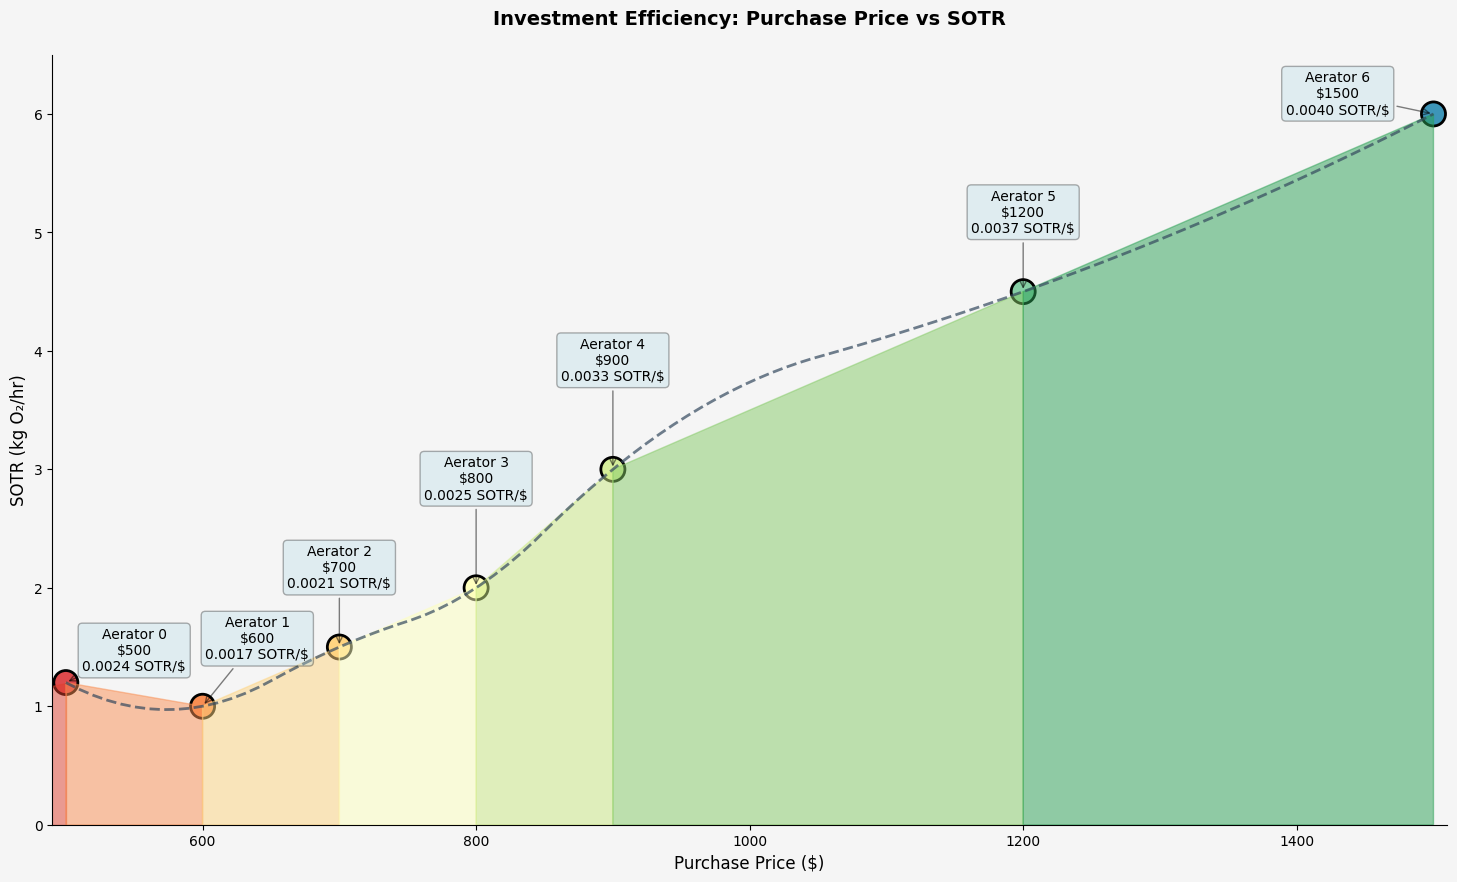

In [176]:
def plot_price_vs_sotr():
    """Create scatter plot of aerator price vs SOTR performance."""
    fig, ax = plt.subplots(figsize=(18, 10))
    fig.patch.set_facecolor("whitesmoke")

    # Create scatter plot with custom colors and styling
    ax = sns.scatterplot(
        x=prices,
        y=sotr_values,
        s=300,  # Increased point size for consistency
        hue=aerator_names,
        palette="Spectral",
        edgecolor="black",
        linewidth=2,
        alpha=1,
        legend=False,  # Disable legend for cleaner look
    )

    # Add smooth trend line if possible
    x_smooth, y_smooth = create_smooth_curve(prices, sotr_values)
    if x_smooth is not None:
        ax.plot(
            x_smooth, y_smooth, "--", color="#34495e", linewidth=2, alpha=0.7
        )

    # Individual gradient fill for each aerator segment
    for i, name in enumerate(aerator_names):
        # Instead of rectangular segments, make them follow the efficiency curve
        if i == 0:
            x_fill = [0, prices[i], prices[i], 0]
            y_fill = [0, 0, sotr_values[i], 0]  # Changed last value to 0
        else:
            x_fill = [prices[i - 1], prices[i], prices[i], prices[i - 1]]
            y_fill = [
                0,
                0,
                sotr_values[i],
                sotr_values[i - 1],
            ]  # Follow the curve better

        ax.fill(
            x_fill, y_fill, color=colors[i], alpha=0.5, label=f"{name} Area"
        )

    # Manual annotation positioning with improved layout
    manual_positions = [
        (550, 1.3),  # Baseline Aerator
        (640, 1.4),  # Aerator 1
        (700, 2.0),  # Aerator 2
        (800, 2.75),  # Aerator 3
        (900, 3.75),  # Aerator 4
        (1200, 5),  # Aerator 5
        (1430, 6.0),  # Aerator 6
    ]

    # Add informative annotations for each aerator with slope and integral data
    for i, (price, sotr, name) in enumerate(
        zip(prices, sotr_values, aerator_names)
    ):
        # Get marginal metrics if available
        if i > 0:
            key = f"{aerator_names[i - 1]}_to_{aerator_names[i]}"
            slope = marginal_metrics[key]["derivative"]
            gain = marginal_metrics[key]["cumulative_gain"]
        else:
            slope = 0  # No prior point for baseline
            gain = 0

        # Use manual positions
        ann_x, ann_y = manual_positions[i]

        # Single merged annotation with all information
        ax.annotate(
            f"{name}\n${price}\n{sotr_per_dollar[i]:.4f} SOTR/$",
            xy=(price, sotr),
            xytext=(ann_x, ann_y),
            fontsize=10,
            ha="center",
            bbox=dict(boxstyle="round", facecolor="lightblue", alpha=0.3),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.5),
        )

    # Customize plot appearance
    ax.set_xlabel("Purchase Price ($)", fontsize=12)
    ax.set_xlim(490, 1510)
    ax.set_ylim(0, 6.5)
    ax.set_ylabel("SOTR (kg O₂/hr)", fontsize=12)
    ax.set_title(
        "Investment Efficiency: Purchase Price vs SOTR\n",
        fontweight="bold",
        fontsize=14,
    )
    ax.grid(False)
    ax.set_facecolor("whitesmoke")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    fig.patch.set_color("whitesmoke")
    return fig, ax


# Generate plots
fig, ax = plot_price_vs_sotr()
plt.show()


</div>
<div class="equation-block">
<h5>2.3.1.3 Standard Aeration Efficiency (SAE)</h5>

$$
\text{SAE} = \frac{\text{SOTR}}{\text{Power (kW)}} \quad ( kg \ O_2 / \text{kWh})
$$

Where $\text{Power (kW)} = \text{Power (HP)} \times 0.746$ (Kumar et al., 2020).

</div>


<div class="equation-block">
<h5>2.3.1.4 Aerator Quantity Calculation</h5>

$$
\text{Number of Aerators} = \left\lceil \frac{TOD}{OTR_T} \right\rceil
$$

</div>


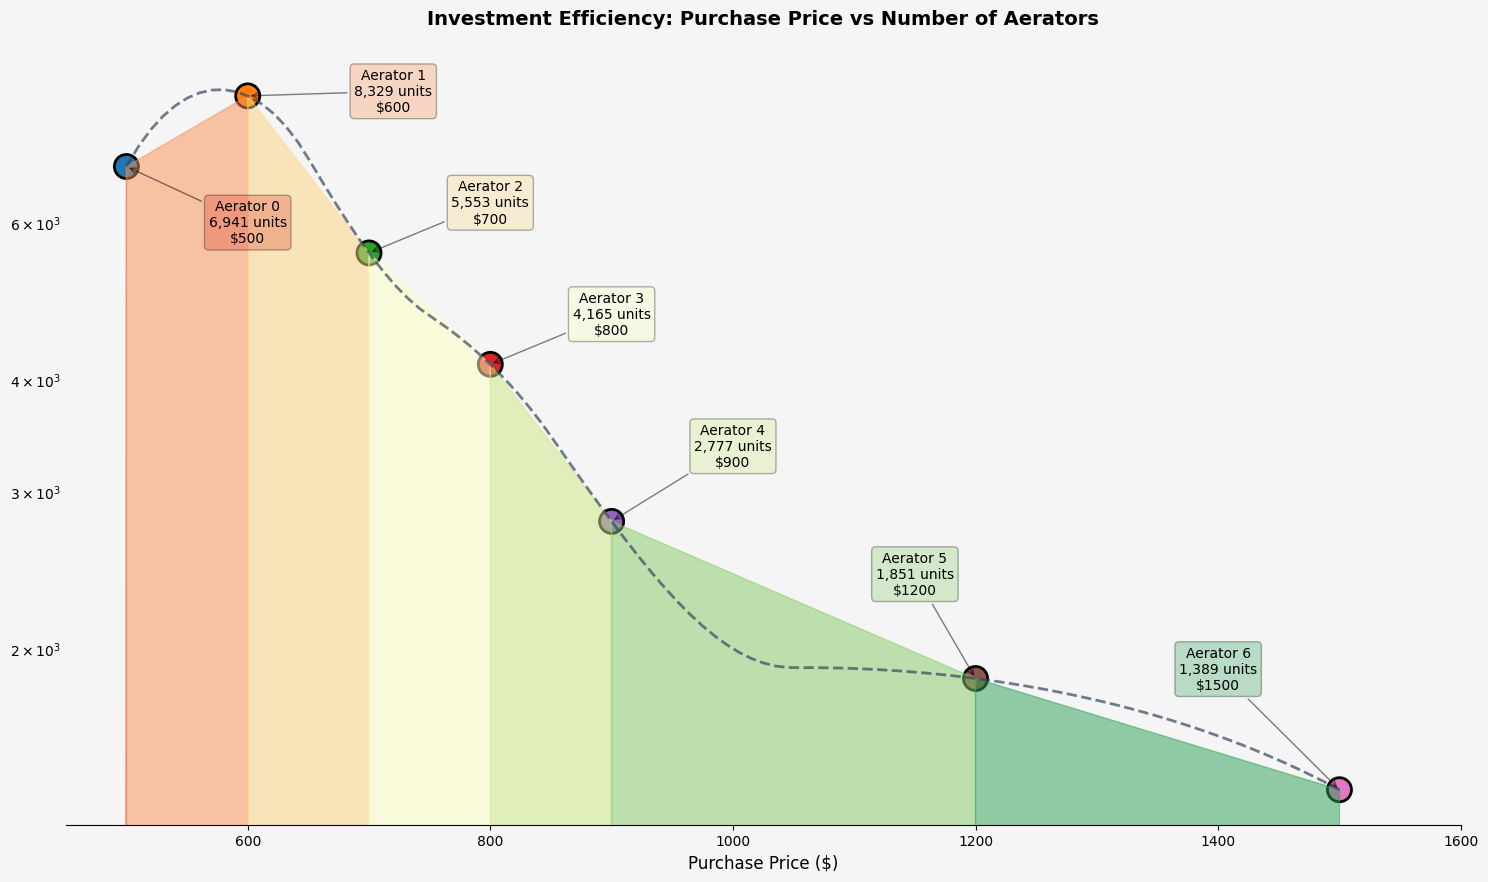

In [151]:
def plot_aerator_quantity():
    """Plot aerator quantity requirements with logarithmic scaling for marginal effects."""
    fig, ax = plt.subplots(figsize=(18, 10))

    # Get data
    aerator_counts = [
        financial_metrics[name]["num_aerators"] for name in aerator_names
    ]

    fig.patch.set_facecolor("whitesmoke")
    
    # Plot Price vs Aerator Quantity (log scale for marginal effects)
    ax = sns.scatterplot(
        x=prices,
        y=aerator_counts,
        s=300,
        hue=aerator_names,
        edgecolors="black",
        linewidth=2,
        alpha=1,
        legend=False,  # Disable legend for cleaner look
    )

    # Add smooth trend line
    x_smooth, y_smooth = create_smooth_curve(prices, aerator_counts)
    if x_smooth is not None:
        ax.plot(
            x_smooth, y_smooth, "--", color="#34495e", linewidth=2, alpha=0.7
        )

    # Gradient fill for each aerator with red-to-green progression following natural curve
    for i, name in enumerate(aerator_names):
        if i == 0:
            # First aerator: fill from start to first point
            x_fill = [0] + [prices[i]]
            y_fill = [0] + [aerator_counts[i]]
        else:
            # Subsequent aerators: fill between previous point and current point
            x_fill = [prices[i - 1]] + [prices[i]]
            y_fill = [aerator_counts[i - 1]] + [aerator_counts[i]]

        ax.fill_between(
            x_fill,
            y_fill,
            color=colors[i],
            alpha=0.5,  # Increased alpha since segments won't overlap
            label=f"{name} Area",
        )

    # Set logarithmic scale for y-axis to capture marginal effects
    ax.set_yscale("log")

    # Manual annotation positioning with improved layout
    manual_positions = [
        (600, 5700),  # Aerator 0
        (720, 8000),  # Aerator 1
        (800, 6000),  # Aerator 2
        (900, 4500),  # Aerator 3
        (1000, 3200),  # Aerator 4
        (1150, 2300),  # Aerator 5
        (1400, 1800),  # Aerator 6
    ]

    # Annotate each point with single merged annotation box containing all info
    for i, (price, count, name) in enumerate(
        zip(prices, aerator_counts, aerator_names)
    ):
        # Get marginal metrics if available
        if i > 0:
            key = f"{aerator_names[i - 1]}_to_{aerator_names[i]}"
            slope = marginal_metrics[key]["derivative"]
            gain = marginal_metrics[key]["cumulative_gain"]
        else:
            slope = 0  # No prior point for baseline
            gain = 0

        # Use manual positions
        ann_x, ann_y = manual_positions[i]

        # Single merged annotation with all information
        ax.annotate(
            f"{name}\n{count:,} units\n${price}",
            xy=(price, count),
            xytext=(ann_x, ann_y),
            fontsize=10,
            ha="center",
            bbox=dict(boxstyle="round", facecolor=colors[i], alpha=0.3),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.5),
        )

    ax.set_xlabel("Purchase Price ($)", fontsize=12)
    ax.set_ylabel("")
    ax.set_title(
        "Investment Efficiency: Purchase Price vs Number of Aerators\n",
        fontweight="bold",
        fontsize=14,
    )
    ax.set_xlim(450, 1600)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_yticklabels("", alpha=0.0)
    ax.set_yticks([])  # Hide y-ticks since we use log scale
    ax.tick_params(axis='y', which='both', length=0)
    
    ax.set_facecolor("whitesmoke")

    ax.grid(False)
    return fig, ax


fig, ax = plot_aerator_quantity()
plt.show()


### 2.3.2 Annual Revenue

$$
\text{Annual Revenue} = \text{Total Annual Production (kg)} \times \text{Shrimp Price (\$/kg)}
$$

Production depends on density, depth, area, and culture cycles (Engle, 2010).


### 2.3.3 Initial Investment

$$
\text{Total Initial Cost} = \text{Number of Aerators} \times \text{Cost per Aerator}
$$


### 2.3.4 Annual Operating Costs

1. **Energy Cost:** $\text{Power (kW)} \times \text{Energy Cost (\$/kWh)} \times \text{Operating Hours per Year} \times \text{Number of Aerators}$
2. **Maintenance Cost:** $\text{Maintenance Cost per Unit per Year} \times \text{Number of Aerators}$
3. **Replacement Cost (Annualized):** $(\text{Number of Aerators} \times \text{Cost per Aerator}) / \text{Durability (years)}$


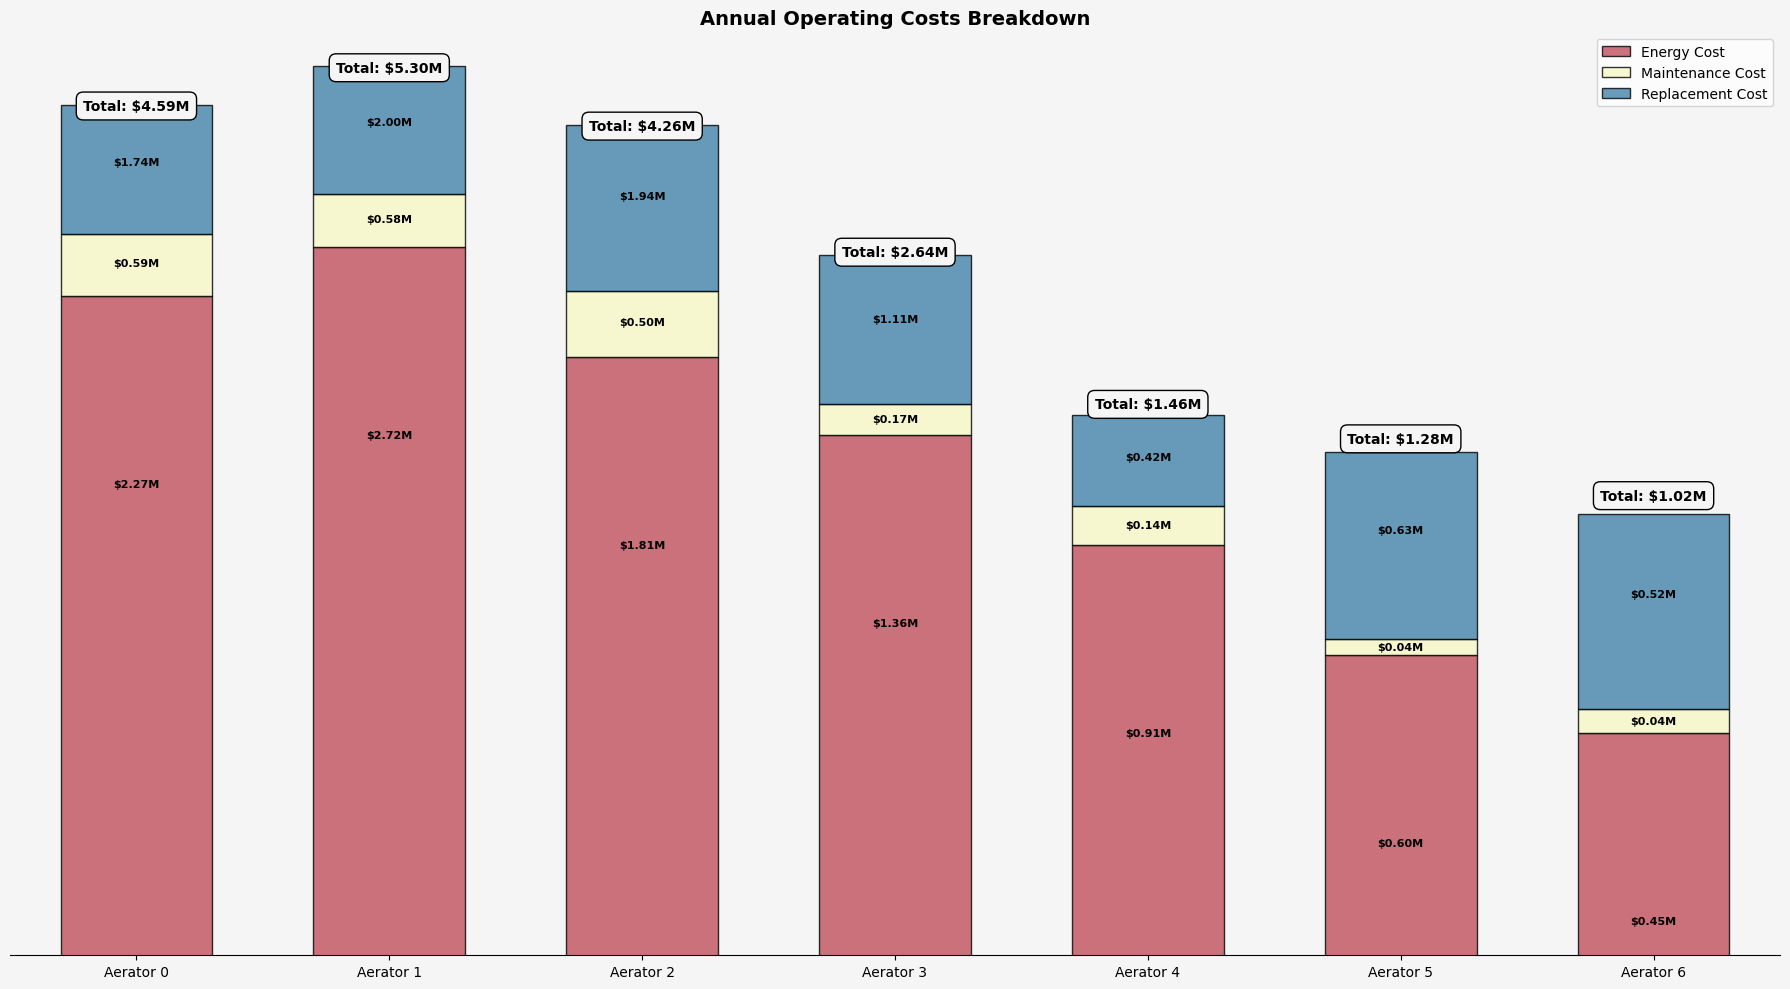

In [112]:
def plot_annual_costs_breakdown():
    """Plot annual operating costs breakdown with enhanced styling and analysis."""
    fig, ax = plt.subplots(figsize=(18, 10))

    # Get cost data
    energy_costs = [
        financial_metrics[name]["annual_energy_cost"] for name in aerator_names
    ]
    maintenance_costs = [
        financial_metrics[name]["annual_maintenance_cost"]
        for name in aerator_names
    ]
    replacement_costs = [
        financial_metrics[name]["annual_replacement_cost"]
        for name in aerator_names
    ]
    total_costs = [
        financial_metrics[name]["total_annual_cost"] for name in aerator_names
    ]

    # Create stacked bar chart
    width = 0.6
    x_pos = np.arange(len(aerator_names))

    # Convert to millions for display
    energy_millions = [e / 1e6 for e in energy_costs]
    maintenance_millions = [m / 1e6 for m in maintenance_costs]
    replacement_millions = [r / 1e6 for r in replacement_costs]

    # Create stacked bars with different patterns/colors for each cost type
    # Define a color palette for cost categories
    cost_palette = sns.color_palette("Spectral", 9)

    ax = sns.barplot(
        x=x_pos,
        y=energy_millions,
        label="Energy Cost",
        color=cost_palette[0],  # First color from palette for energy
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
        width=width,
    )

    ax = sns.barplot(
        x=x_pos,
        y=maintenance_millions,
        bottom=energy_millions,
        label="Maintenance Cost",
        color=cost_palette[4],  # Second color for maintenance
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
        width=width,
    )

    ax = sns.barplot(
        x=x_pos,
        y=replacement_millions,
        bottom=[e + m for e, m in zip(energy_millions, maintenance_millions)],
        label="Replacement Cost",
        color=cost_palette[8],  # Third color for replacement
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
        width=width,
    )

    # Add value labels on each stack segment
    for i, name in enumerate(aerator_names):
        # Energy cost label
        ax.text(
            i,
            energy_millions[i] / 2,
            f"${energy_millions[i]:.2f}M",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=8,
        )

        # Maintenance cost label
        ax.text(
            i,
            energy_millions[i] + maintenance_millions[i] / 2,
            f"${maintenance_millions[i]:.2f}M",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=8,
        )

        # Replacement cost label
        ax.text(
            i,
            energy_millions[i]
            + maintenance_millions[i]
            + replacement_millions[i] / 2,
            f"${replacement_millions[i]:.2f}M",
            ha="center",
            va="center",
            fontweight="bold",
            fontsize=8,
        )

        # Total cost label above each bar
        total_million = total_costs[i] / 1e6
        ax.text(
            i,
            total_million + 0.1,
            f"Total: ${total_million:.2f}M",
            ha="center",
            va="top",
            fontweight="bold",
            fontsize=10,
            bbox=dict(
                boxstyle="round,pad=0.5", facecolor="whitesmoke", alpha=1
            ),
        )

    ax.set_title(
        "Annual Operating Costs Breakdown",
        fontweight="bold",
        fontsize=14,
    )
    ax.set_yscale("log")  # Logarithmic scale for better visibility
    ax.set_ylim(0.2, 6)  # Set limits to capture all costs
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(x_pos)
    ax.set_xticklabels(aerator_names, rotation=0)
    # Remove the y ticker marks
    ax.set_yticklabels("", alpha=0.0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Remove the y-axis tick marks
    ax.tick_params(axis='y', which='both', length=0)
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.0, axis="y")
    ax.set_facecolor("whitesmoke")
    fig.patch.set_facecolor("whitesmoke")

    plt.tight_layout()
    return fig, ax


fig, ax = plot_annual_costs_breakdown()
plt.show()



### 2.3.6 Net Present Value (NPV) of Savings

$$
\text{NPV}_{\text{Savings}} = \sum_{i=1}^{n} \frac{\text{Annual Saving}_{\text{Year 1}} \times (1 + r_{\text{inflation}})^{i-1}}{(1 + r_{real})^i}
$$

Where $r_{real} = \frac{1 + r_{nominal}}{1 + r_{inflation}} - 1$ (Intelligon, 2022; Susilowati et al., 2021).


### 2.3.7 Adapted Financial Metrics

Standard metrics (IRR, Payback, ROI, k) were adapted due to violations of positive incremental investment assumptions in aquaculture equipment comparison (Engle, 2010; Kumar et al., 2020).


#### 2.3.7.1 Internal Rate of Return (IRR)

$$
0 = - \Delta I + \sum_{i=1}^{n} \frac{S_{yr1} \times (1 + r_{\text{inflation}})^{i-1}}{(1 + \text{IRR})^i}
$$

If $\Delta I \leq 0$, standard IRR is undefined; adapted IRR anchors against baseline cost, scaled by SOTR ratio, capped at 100% (Kumar et al., 2020).


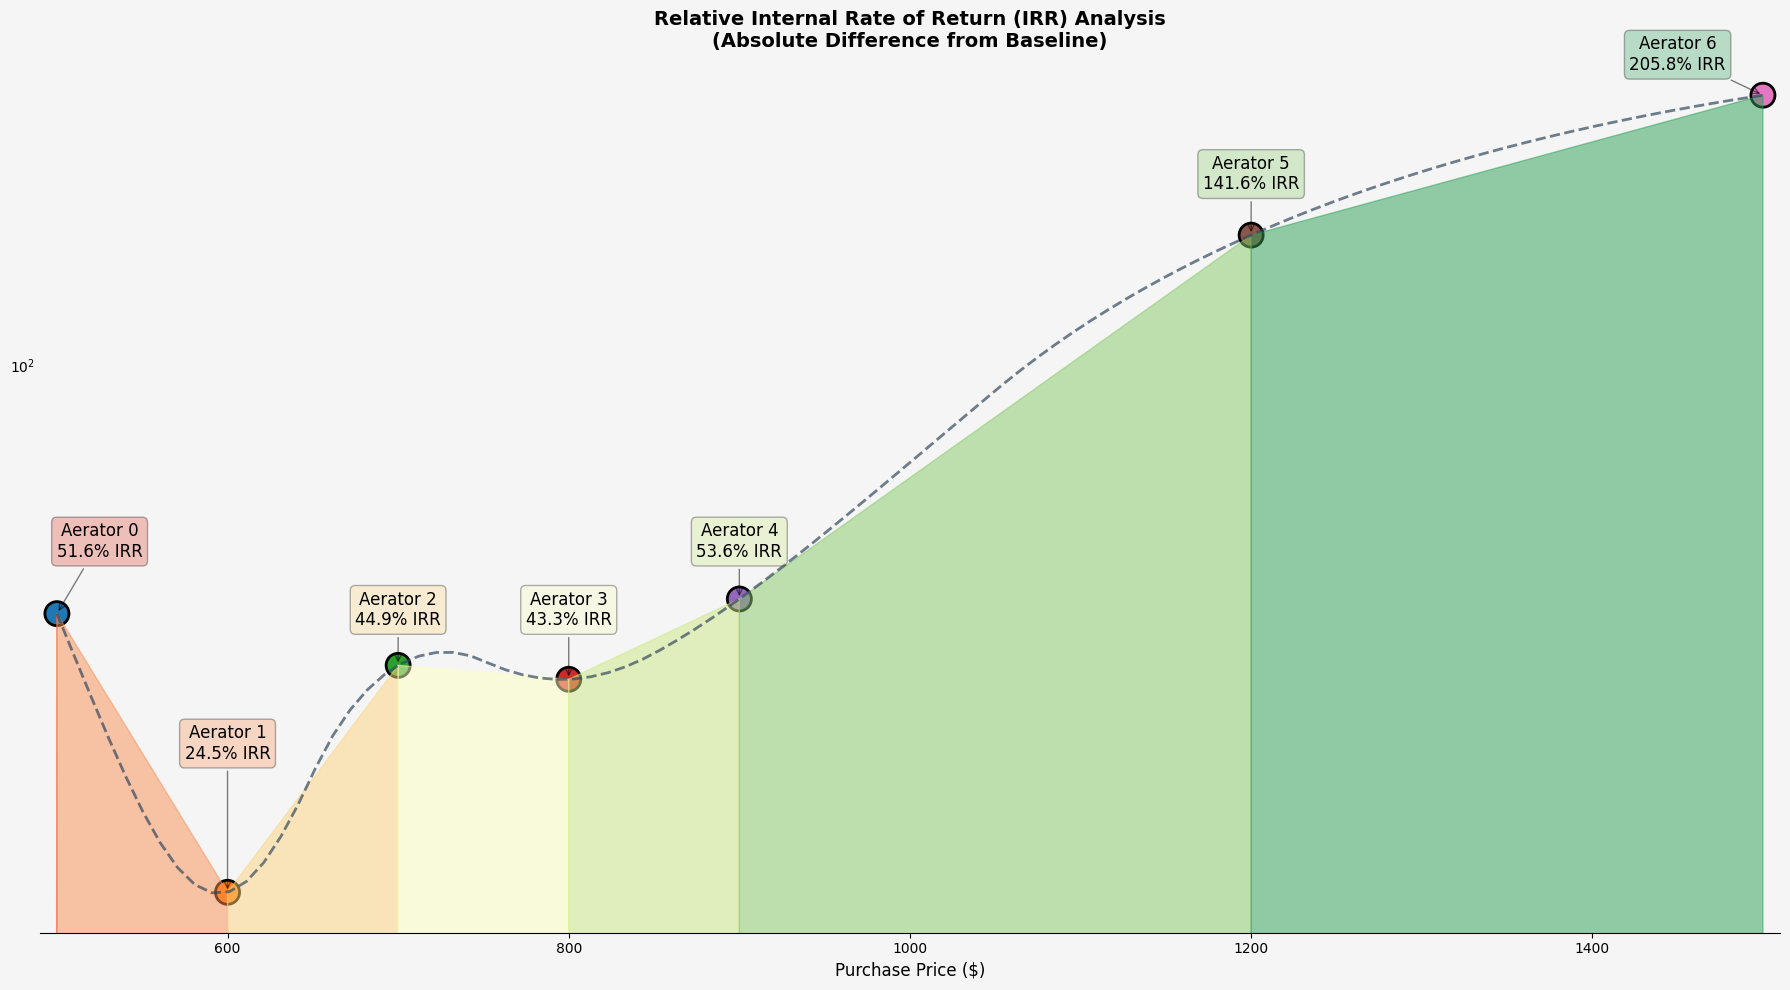

In [152]:
def plot_irr_analysis():
    """Plot IRR analysis with absolute difference from baseline aerator using scatter plot with log scale."""
    fig, ax = plt.subplots(figsize=(18, 10))

    # Get IRR data - but adjust so Baseline Aerator = 0% and others show actual differences
    baseline_aerator_irr = 0.0  # Baseline should be 0% reference

    # Calculate actual IRR values relative to baseline
    irr_values = []
    for name in aerator_names:
        if name == "Baseline Aerator":
            irr_values.append(0.0)  # Baseline is 0% reference
        else:
            # Use the calculated IRR from financial_metrics
            irr_values.append(financial_metrics[name]["irr"])

    # Calculate absolute differences from baseline (0%)
    irr_diffs = [
        max(abs(irr - baseline_aerator_irr), 0.1) for irr in irr_values
    ]

    # Create scatter plot with custom colors and styling
    ax = sns.scatterplot(
        x=prices,
        y=irr_diffs,
        s=300,
        hue=aerator_names,
        edgecolors="black",
        linewidth=2,
        alpha=1,
        legend=False,  # Disable legend for cleaner look
    )

    # Add smooth trend line if possible
    x_smooth, y_smooth = create_smooth_curve(prices, irr_diffs)
    if x_smooth is not None:
        ax.plot(
            x_smooth, y_smooth, "--", color="#34495e", linewidth=2, alpha=0.7
        )

    # Gradient fill for each aerator with red-to-green progression following natural curve
    for i, name in enumerate(aerator_names):
        if i == 0:
            # First aerator: fill from start to first point
            x_fill = [0] + [prices[i]]
            y_fill = [0] + [irr_diffs[i]]
        else:
            # Subsequent aerators: fill between previous point and current point
            x_fill = [prices[i - 1]] + [prices[i]]
            y_fill = [irr_diffs[i - 1]] + [irr_diffs[i]]

        ax.fill_between(
            x_fill,
            y_fill,
            color=colors[i],
            alpha=0.5,  # Increased alpha since segments won't overlap
            label=f"{name} Area",
        )

    # Set logarithmic scale for y-axis
    ax.set_yscale("log")

    # Manual annotation positioning with improved layout
    manual_positions = [
        (525, 60),  # Aerator 0 - reference point at bottom
        (600, 35),  # Aerator 1
        (700, 50),  # Aerator 2
        (800, 50),  # Aerator 3
        (900, 60),  # Aerator 4
        (1200, 160),  # Aerator 5
        (1450, 220),  # Aerator 6 - highest difference
    ]

    # Add informative annotations for each aerator
    for i, (price, irr_val, diff, name) in enumerate(
        zip(prices, irr_values, irr_diffs, aerator_names)
    ):
        # Get marginal metrics if available
        if i > 0:
            key = f"{aerator_names[i - 1]}_to_{aerator_names[i]}"
            slope = marginal_metrics[key]["derivative"]
            gain = marginal_metrics[key]["cumulative_gain"]
        else:
            slope = 0  # No prior point for baseline
            gain = 0

        # Use manual positions
        ann_x, ann_y = manual_positions[i]

        # Single merged annotation with all information
        ax.annotate(
            f"{name}\n{irr_val:.1f}% IRR",
            xy=(price, diff),
            xytext=(ann_x, ann_y),
            fontsize=12,
            ha="center",
            bbox=dict(boxstyle="round", facecolor=colors[i], alpha=0.3),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.5),
        )

    ax.set_title(
        "Relative Internal Rate of Return (IRR) Analysis\n(Absolute Difference from Baseline)",
        fontweight="bold",
        fontsize=14,
    )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_facecolor("whitesmoke")
    fig.patch.set_facecolor("whitesmoke")
    ax.set_xlabel("Purchase Price ($)", fontsize=12)
    ax.set_xlim(490, 1510)
    ax.tick_params(axis="y", which="both", length=0)
    ax.set_ylabel("")
    ax.grid(False)

    plt.tight_layout()
    return fig, ax


fig, ax = plot_irr_analysis()
plt.show()


#### 2.3.7.2 Payback Period

$$
\text{Payback Period} =
\begin{cases}
\frac{0.01}{R_{SOTR}} & \text{if } \Delta I < 0 \text{ and } S_{yr1} > 0 \\
\frac{\Delta I}{S_{yr1}} & \text{if } \Delta I \geq 0 \text{ and } S_{yr1} > 0 \\
\infty & \text{if } S_{yr1} \leq 0
\end{cases}
$$

If $\Delta I \leq 0$, a small value divided by SOTR ratio indicates immediate benefit (Susilowati et al., 2021).


#### 2.3.7.3 Return on Investment (ROI)

$$
\text{ROI}_{\text{relative}} =
\begin{cases}
\min\left( \left( \frac{S_{yr1}}{C_{base}} \times R_{SOTR} \times (1 + F_{cost\_sav}) \right) \times 100, R_{SOTR} \times 100 \right) & \text{if } \Delta I < 0 \text{ and } S_{yr1} > 0 \\
\min\left( \left( \frac{S_{yr1}}{C_{base}} \times R_{SOTR} \right) \times 100, R_{SOTR} \times 100 \right) & \text{if } \Delta I = 0 \text{ and } S_{yr1} > 0 \\
\min\left( \left( \frac{S_{yr1}}{\Delta I} \right) \times 100, R_{SOTR} \times 100 \right) & \text{if } \Delta I > 0 \text{ and } S_{yr1} > 0 \\
0 & \text{if } S_{yr1} \leq 0 \text{ or } C_{base} \leq 0
\end{cases}
$$

Where $F_{cost\_sav} = \frac{|\Delta I|}{C_{base}}$. If $\Delta I \leq 0$, relative ROI is based on savings relative to baseline cost, scaled by SOTR ratio (Intelligon, 2022).


#### 2.3.7.4 Profitability Index (k)

$$
k_{\text{relative}} =
\begin{cases}
k_{base} \times (1 + F_{cost\_sav}) & \text{if } \Delta I < 0 \\
k_{base} & \text{if } \Delta I = 0 \\
k_{base} \times F_{cost} & \text{if } \Delta I > 0 \\
0 & \text{if } NPV_{sav} \leq 0 \text{ or } C_{base} \leq 0
\end{cases}
$$

Where $k_{base} = \frac{NPV_{sav}}{C_{base}} \times R_{SOTR}$, $F_{cost\_sav} = \frac{|\Delta I|}{C_{base}}$, $F_{cost} = \frac{C_{base}}{C_{base} + \Delta I}$ (Engle, 2010).


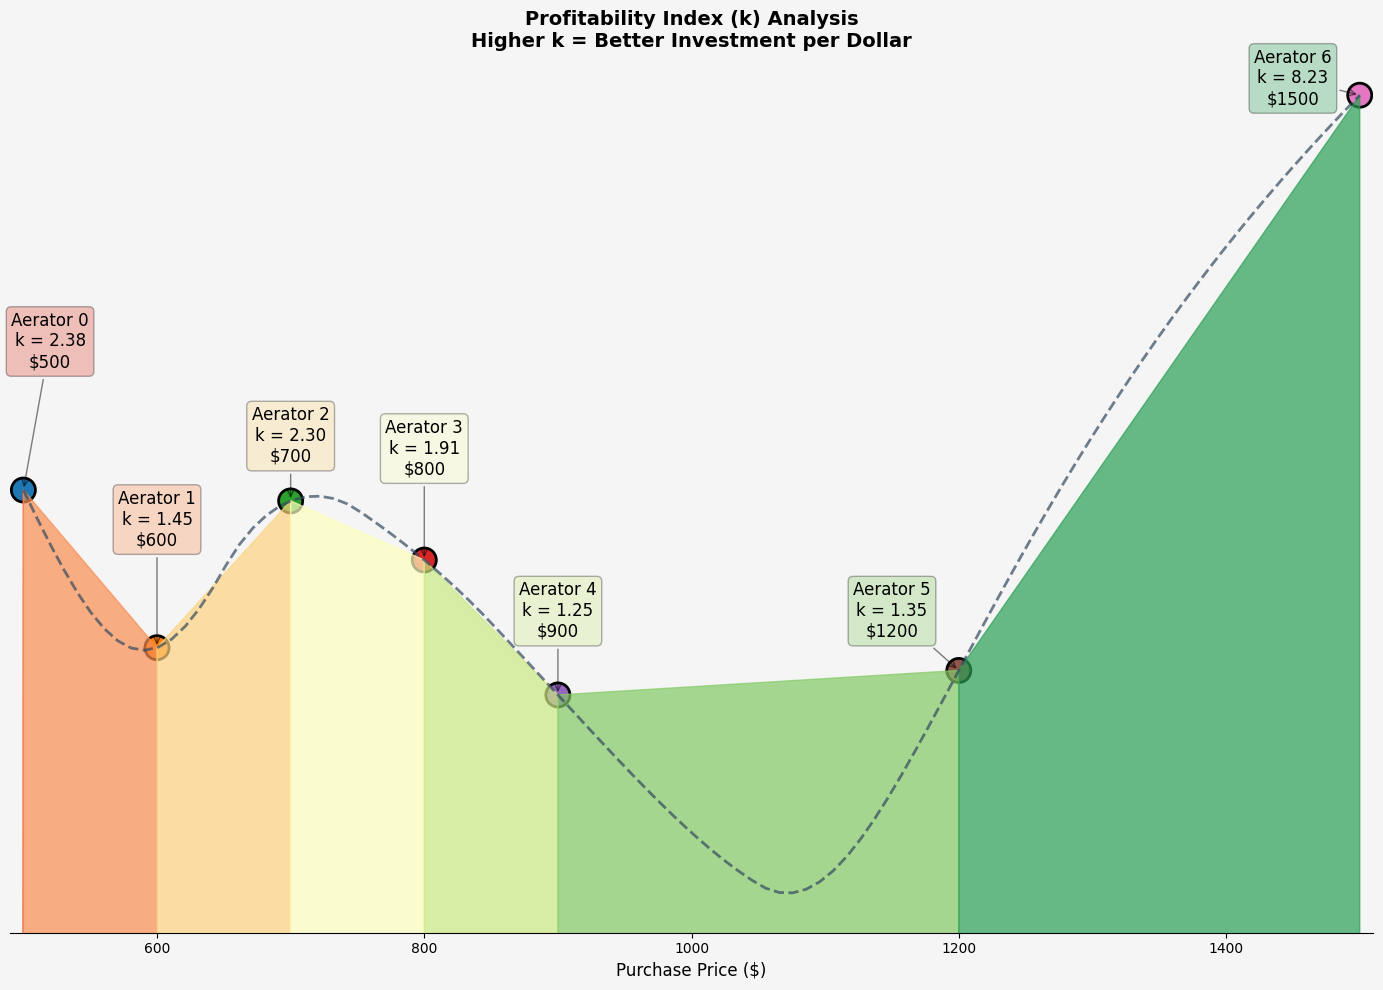

In [ ]:
def plot_profitability_index():
    """Plot profitability index (k) analysis with enhanced styling."""
    fig, ax = plt.subplots(figsize=(14, 10))

    # Get profitability index data
    k_values = [
        financial_metrics[name]["profitability_k"] for name in aerator_names
    ]

    # Create scatter plot with custom colors and styling
    ax = sns.scatterplot(
        x=prices,
        y=k_values,
        s=300,
        hue=aerator_names,
        edgecolors="black",
        linewidth=2,
        alpha=1,
        legend=False,  # Disable legend for cleaner look
    )

    # Add smooth trend line if possible
    x_smooth, y_smooth = create_smooth_curve(prices, k_values)
    if x_smooth is not None:
        ax.plot(
            x_smooth, y_smooth, "--", color="#34495e", linewidth=2, alpha=0.7
        )

    for i, name in enumerate(aerator_names):
        if i == 0:
            # First aerator: fill from start to first point
            x_fill = [0] + [prices[i]]
            y_fill = [0] + [k_values[i]]
        else:
            # Subsequent aerators: fill between previous point and current point
            x_fill = [prices[i - 1]] + [prices[i]]
            y_fill = [k_values[i - 1]] + [k_values[i]]

        ax.fill_between(
            x_fill,
            y_fill,
            color=colors[i],
            alpha=0.7,  # Increased alpha since segments won't overlap
            label=f"{name} Area",
        )

    # Manual annotation positioning - adjusted for new k values
    manual_positions = [
        (520, 3.5),  # Aerator 0
        (600, 2.0),  # Aerator 1
        (700, 2.6),  # Aerator 2
        (800, 2.5),  # Aerator 3
        (900, 1.5),  # Aerator 4
        (1150, 1.5),  # Aerator 5
        (1450, 8.0),  # Aerator 6
    ]

    # Add informative annotations for each aerator
    for i, (price, k_val, name) in enumerate(
        zip(prices, k_values, aerator_names)
    ):
        # Get marginal metrics if available
        if i > 0:
            key = f"{aerator_names[i - 1]}_to_{aerator_names[i]}"
            slope = marginal_metrics[key]["derivative"]
            gain = marginal_metrics[key]["cumulative_gain"]
        else:
            slope = 0  # No prior point for baseline
            gain = 0

        # Use manual positions
        ann_x, ann_y = manual_positions[i]

        # Single merged annotation with all information
        ax.annotate(
            f"{name}\nk = {k_val:.2f}\n${price}",
            xy=(price, k_val),
            xytext=(ann_x, ann_y),
            fontsize=12,
            ha="center",
            bbox=dict(boxstyle="round", facecolor=colors[i], alpha=0.3),
            arrowprops=dict(arrowstyle="->", color="black", alpha=0.5),
        )

    ax.set_title(
        "Profitability Index (k) Analysis\nHigher k = Better Investment per Dollar",
        fontweight="bold",
        fontsize=14,
    )
    ax.set_xlabel("Purchase Price ($)", fontsize=12)
    ax.set_ylabel("")
    ax.set_yscale("log")  # Logarithmic scale for better visibility
    ax.set_xlim(490, 1510)
    ax.set_yticklabels("", alpha=0.0)
    ax.set_yticks([])  # Hide y-ticks since we use log scale
    ax.tick_params(axis="y", which="both", length=0)
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_facecolor("whitesmoke")
    fig.patch.set_facecolor("whitesmoke")

    plt.tight_layout()
    return fig, ax


fig, ax = plot_profitability_index()
plt.show()


#### 2.3.7.6 Equilibrium Price

$$
P_{eq} =
\begin{cases}
\max\left(0, P_{base} \times R_{SOTR} \times \left(\frac{1}{1 + F_{cost, eq}}\right)\right) & \text{if } C_{base} > 0 \text{ and } P_{base} > 0 \\
\max\left(0, P_{base} \times R_{SOTR}\right) & \text{if } C_{base} \leq 0 \text{ or } P_{base} \leq 0 \\
0 & \text{if calculation prerequisites fail}
\end{cases}
$$

Where $P_{base} = \frac{(C_{\text{annual, non-winner}} - (C_{E, \text{winner}} + C_{M, \text{winner}})) \times D_{\text{winner}}}{N_{\text{winner}}}$, $F_{cost, eq} = P_{base} / C_{base}$ (Asche et al., 2021).


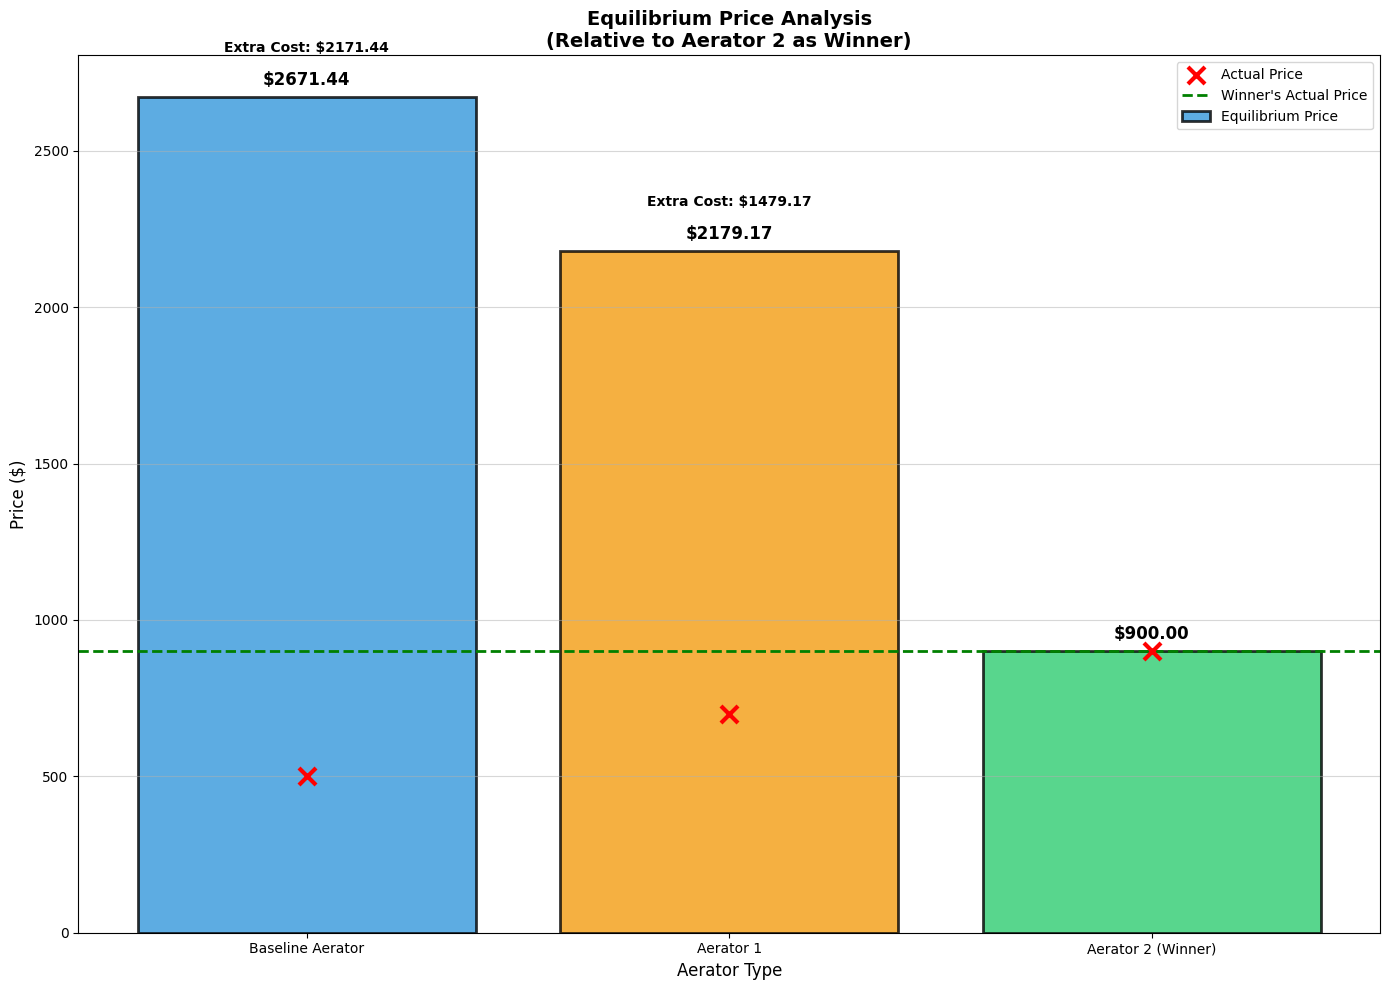

In [28]:
def plot_equilibrium_price():
    """Plot equilibrium price analysis based on Aerator 2 as winner."""
    fig, ax = plt.subplots(figsize=(14, 10))

    # Calculate equilibrium prices relative to Aerator 2 (winner)
    winner_name = baseline_name  # Aerator 2
    winner_data = financial_metrics[winner_name]

    equilibrium_prices = []
    actual_prices = []
    aerator_labels = []

    for name in aerator_names:
        if name != winner_name:
            eq_price = calculate_equilibrium_price(
                financial_metrics[name]["total_annual_cost"],
                winner_data["annual_energy_cost"],
                winner_data["annual_maintenance_cost"],
                winner_data["num_aerators"],
                aerator_specs[winner_name]["durability"],
                performance_data[name]["sotr"]
                / performance_data[winner_name]["sotr"],
                winner_data["initial_investment"],
            )
            equilibrium_prices.append(eq_price)
            actual_prices.append(aerator_specs[name]["price"])
            aerator_labels.append(name)
        else:
            # Winner's actual price = equilibrium price
            equilibrium_prices.append(aerator_specs[name]["price"])
            actual_prices.append(aerator_specs[name]["price"])
            aerator_labels.append(f"{name} (Winner)")

    # Create bar chart for equilibrium prices
    x_pos = np.arange(len(aerator_labels))
    bars = ax.bar(
        x_pos,
        equilibrium_prices,
        color=[
            aerator_color_map[name.replace(" (Winner)", "")] for name in aerator_labels
        ],
        alpha=0.8,
        edgecolor="black",
        linewidth=2,
        label="Equilibrium Price",
    )

    # Add value labels on bars
    for i, (bar, price) in enumerate(zip(bars, equilibrium_prices)):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(equilibrium_prices) * 0.01,
            f"${price:.2f}",
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=12,
        )

    # Add actual prices as red 'x' markers
    ax.scatter(
        x_pos,
        actual_prices,
        s=150,
        c="red",
        marker="x",
        linewidth=3,
        label="Actual Price",
        zorder=5,
    )

    # Add horizontal line for winner's actual price
    winner_price = aerator_specs[winner_name]["price"]
    ax.axhline(
        y=winner_price,
        color="green",
        linestyle="--",
        linewidth=2,
        label="Winner's Actual Price",
    )

    # Annotate additional costs for non-winners
    for i, (eq_price, actual_price, name) in enumerate(
        zip(equilibrium_prices, actual_prices, aerator_labels)
    ):
        if name != f"{winner_name} (Winner)":
            diff = eq_price - actual_price
            ax.annotate(
                f"Extra Cost: ${diff:.2f}",
                xy=(x_pos[i], eq_price),
                xytext=(x_pos[i], eq_price + max(equilibrium_prices) * 0.05),
                ha="center",
                va="bottom",
                fontweight="bold",
                fontsize=10,
                color="black",
            )

    # Customize plot
    ax.set_title(
        "Equilibrium Price Analysis\n(Relative to Aerator 2 as Winner)",
        fontweight="bold",
        fontsize=14,
    )
    ax.set_ylabel("Price ($)", fontsize=12)
    ax.set_xlabel("Aerator Type", fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(aerator_labels, rotation=0)
    ax.legend()
    ax.grid(True, alpha=0.5, axis="y")

    plt.tight_layout()
    return fig, ax

fig6, ax6 = plot_equilibrium_price()
plt.show()


#### 2.3.7.5 Opportunity Cost

$$
\text{Opportunity Cost}_{\text{baseline}} = \text{NPV}_{\text{Savings (winner vs. baseline)}}
$$

Quantifies economic loss from less efficient equipment (Boyd & Hanson, 2021; Susilowati et al., 2021).


In [29]:
# Create HTML table for performance summary
html_performance = """
<h2>AERATOR PERFORMANCE SUMMARY</h2>
<table border="1" style="border-collapse: collapse; width: 100%; margin: 20px 0;">
<thead>
<tr style="background-color: transparent;">
<th style="padding: 12px; text-align: left;">Aerator</th>
<th style="padding: 12px; text-align: center;">SOTR (kg O₂/hr)</th>
<th style="padding: 12px; text-align: center;">Price ($)</th>
<th style="padding: 12px; text-align: center;">Annual Production (kg O₂/year)</th>
<th style="padding: 12px; text-align: center;">Cost Efficiency ($/kg O₂)</th>
<th style="padding: 12px; text-align: center;">Cost per SOTR ($/SOTR)</th>
<th style="padding: 12px; text-align: center;">SOTR per Dollar</th>
</tr>
</thead>
<tbody>
"""

for name in aerator_names:
    data = performance_data[name]
    html_performance += f"""
<tr>
<td style="padding: 12px; font-weight: bold;">{name}</td>
<td style="padding: 12px; text-align: center;">{data["sotr"]:.1f}</td>
<td style="padding: 12px; text-align: center;">${data["price"]:,}</td>
<td style="padding: 12px; text-align: center;">{data["annual_o2"]:,.0f}</td>
<td style="padding: 12px; text-align: center;">${data["cost_per_kg_o2"]:.3f}</td>
<td style="padding: 12px; text-align: center;">${data["cost_per_sotr"]:.0f}</td>
<td style="padding: 12px; text-align: center;">{data["sotr_per_dollar"]:.4f}</td>
</tr>
"""

html_performance += """
</tbody>
</table>
"""

# Create farm-scale financial analysis table
html_financial = f"""
<h2>FARM-SCALE FINANCIAL ANALYSIS</h2>
<p><strong>Farm Parameters:</strong> {farm_area_hectares:,} hectares, TOD: {total_oxygen_demand:,.0f} kg O₂/hr, 
Annual Revenue: ${annual_revenue / 1e6:.1f}M, Analysis Period: {analysis_years} years</p>
<table border="1" style="border-collapse: collapse; width: 100%; margin: 20px 0;">
<thead>
<tr style="background-color: transparent;">
<th style="padding: 12px; text-align: left;">Aerator</th>
<th style="padding: 12px; text-align: center;">Quantity Required</th>
<th style="padding: 12px; text-align: center;">Units/Hectare</th>
<th style="padding: 12px; text-align: center;">Initial Investment ($M)</th>
<th style="padding: 12px; text-align: center;">Annual Energy Cost ($M)</th>
<th style="padding: 12px; text-align: center;">Annual Maintenance ($M)</th>
<th style="padding: 12px; text-align: center;">Annual Replacement ($M)</th>
<th style="padding: 12px; text-align: center;">Total Annual Cost ($M)</th>
<th style="padding: 12px; text-align: center;">Cost as % Revenue</th>
<th style="padding: 12px; text-align: center;">NPV Opportunity Cost ($M)</th>
</tr>
</thead>
<tbody>
"""

for name in aerator_names:
    data = financial_metrics[name]
    html_financial += f"""
<tr>
<td style="padding: 12px; font-weight: bold;">{name}</td>
<td style="padding: 12px; text-align: center;">{data["num_aerators"]:,}</td>
<td style="padding: 12px; text-align: center;">{data["aerators_per_hectare"]:.2f}</td>
<td style="padding: 12px; text-align: center;">${data["initial_investment"] / 1e6:.2f}</td>
<td style="padding: 12px; text-align: center;">${data["annual_energy_cost"] / 1e6:.2f}</td>
<td style="padding: 12px; text-align: center;">${data["annual_maintenance_cost"] / 1e6:.2f}</td>
<td style="padding: 12px; text-align: center;">${data["annual_replacement_cost"] / 1e6:.2f}</td>
<td style="padding: 12px; text-align: center;">${data["total_annual_cost"] / 1e6:.2f}</td>
<td style="padding: 12px; text-align: center;">{data["cost_as_pct_revenue"]:.1f}%</td>
<td style="padding: 12px; text-align: center;">${data["npv_opportunity_cost"] / 1e6:.1f}</td>
</tr>
"""

html_financial += """
</tbody>
</table>
"""

# Create financial metrics table with all calculated indicators
html_metrics = f"""
<h2>FINANCIAL METRICS ANALYSIS{""}</h2>
<p><strong>Advanced Financial Indicators:</strong> IRR, ROI, Payback Period, Profitability Index, and Equilibrium Price</p>
<table border="1" style="border-collapse: collapse; width: 100%; margin: 20px 0;">
<thead>
<tr style="background-color: transparent;">
<th style="padding: 12px; text-align: left;">Aerator</th>
<th style="padding: 12px; text-align: center;">Internal Rate of Return (%)</th>
<th style="padding: 12px; text-align: center;">Return on Investment (%)</th>
<th style="padding: 12px; text-align: center;">Payback Period (Years)</th>
<th style="padding: 12px; text-align: center;">Profitability Index (k)</th>
<th style="padding: 12px; text-align: center;">Standard Aeration Efficiency (kg O₂/kWh)</th>
<th style="padding: 12px; text-align: center;">Temperature-Adjusted OTR (kg O₂/hr)</th>
<th style="padding: 12px; text-align: center;">Total Power Required (HP)</th>
<th style="padding: 12px; text-align: center;">HP per Hectare</th>
</tr>
</thead>
<tbody>
"""

for name in aerator_names:
    financial_data = financial_metrics[name]
    performance = performance_data[name]
    html_metrics += f"""
<tr>
<td style="padding: 12px; font-weight: bold;">{name}</td>
<td style="padding: 12px; text-align: center;">{financial_data["irr"]:.2f}%</td>
<td style="padding: 12px; text-align: center;">{financial_data["roi"]:.2f}%</td>
<td style="padding: 12px; text-align: center;">{financial_data["payback"]:.2f}</td>
<td style="padding: 12px; text-align: center;">{financial_data["profitability_k"]:.2f}</td>
<td style="padding: 12px; text-align: center;">{performance["sae"]:.2f}</td>
<td style="padding: 12px; text-align: center;">{performance["otrt"]:.2f}</td>
<td style="padding: 12px; text-align: center;">{financial_data["total_power_hp"]:,}</td>
<td style="padding: 12px; text-align: center;">{financial_data["hp_per_hectare"]:.2f}</td>
</tr>
"""

html_metrics += """
</tbody>
</table>
"""

# Create equilibrium price analysis table
html_equilibrium = f"""
<h2>EQUILIBRIUM PRICE ANALYSIS</h2>
<p><strong>Market Equilibrium:</strong> Theoretical prices based on Walras's General Equilibrium Theory (relative to {baseline_name} as winner)</p>
<table border="1" style="border-collapse: collapse; width: 100%; margin: 20px 0;">
<thead>
<tr style="background-color: transparent;">
<th style="padding: 12px; text-align: left;">Aerator</th>
<th style="padding: 12px; text-align: center;">Actual Price ($)</th>
<th style="padding: 12px; text-align: center;">Equilibrium Price ($)</th>
<th style="padding: 12px; text-align: center;">Price Difference ($)</th>
<th style="padding: 12px; text-align: center;">Market Status</th>
<th style="padding: 12px; text-align: center;">Durability (Years)</th>
<th style="padding: 12px; text-align: center;">Annual Maintenance ($/unit)</th>
<th style="padding: 12px; text-align: center;">Cost-Effectiveness Rating</th>
</tr>
</thead>
<tbody>
"""

# Calculate equilibrium prices for the table
winner_data = financial_metrics[baseline_name]
for name in aerator_names:
    actual_price = aerator_specs[name]["price"]

    if name != baseline_name:
        eq_price = calculate_equilibrium_price(
            financial_metrics[name]["total_annual_cost"],
            winner_data["annual_energy_cost"],
            winner_data["annual_maintenance_cost"],
            winner_data["num_aerators"],
            aerator_specs[baseline_name]["durability"],
            performance_data[name]["sotr"]
            / performance_data[baseline_name]["sotr"],
            winner_data["initial_investment"],
        )
        price_diff = eq_price - actual_price
        market_status = (
            "Overpriced"
            if price_diff < 0
            else "Underpriced"
            if price_diff > 0
            else "At Equilibrium"
        )
    else:
        eq_price = actual_price
        price_diff = 0
        market_status = "Winner (Reference)"

    # Cost-effectiveness rating based on SOTR per dollar
    sotr_per_dollar = performance_data[name]["sotr_per_dollar"]
    if sotr_per_dollar >= 0.003:
        effectiveness = "Excellent"
    elif sotr_per_dollar >= 0.0025:
        effectiveness = "Good"
    elif sotr_per_dollar >= 0.002:
        effectiveness = "Fair"
    else:
        effectiveness = "Poor"

    html_equilibrium += f"""
<tr>
<td style="padding: 12px; font-weight: bold;">{name}</td>
<td style="padding: 12px; text-align: center;">${actual_price:,}</td>
<td style="padding: 12px; text-align: center;">${eq_price:.2f}</td>
<td style="padding: 12px; text-align: center;">${price_diff:.2f}</td>
<td style="padding: 12px; text-align: center;">{market_status}</td>
<td style="padding: 12px; text-align: center;">{aerator_specs[name]["durability"]:.1f}</td>
<td style="padding: 12px; text-align: center;">${aerator_specs[name]["maintenance"]}</td>
<td style="padding: 12px; text-align: center;">{effectiveness}</td>
</tr>
"""

html_equilibrium += """
</tbody>
</table>
"""

# Create HTML table for marginal analysis results
html_marginal = """
<h2>MARGINAL ANALYSIS</h2>
<table border="1" style="border-collapse: collapse; width: 100%; margin: 20px 0;">
<thead>
<tr style="background-color: transparent;">
<th style="padding: 12px; text-align: left;">Upgrade Path</th>
<th style="padding: 12px; text-align: center;">Additional Investment ($)</th>
<th style="padding: 12px; text-align: center;">SOTR Gain (kg O₂/hr)</th>
<th style="padding: 12px; text-align: center;">Production Gain (kg O₂/year)</th>
<th style="padding: 12px; text-align: center;">Aerator Count Change</th>
<th style="padding: 12px; text-align: center;">SOTR per Dollar</th>
<th style="padding: 12px; text-align: center;">Production per Dollar (kg O₂/year/$)</th>
<th style="padding: 12px; text-align: center;">Derivative (Slope)</th>
<th style="padding: 12px; text-align: center;">Cumulative Gain (kg O₂)</th>
</tr>
</thead>
<tbody>
"""

for key, metrics in marginal_metrics.items():
    upgrade_path = key.replace("_", " → ").replace("Aerator", "Aerator")
    html_marginal += f"""
<tr>
<td style="padding: 12px; font-weight: bold;">{upgrade_path}</td>
<td style="padding: 12px; text-align: center;">${metrics["investment_diff"]:,}</td>
<td style="padding: 12px; text-align: center;">{metrics["sotr_diff"]:.1f}</td>
<td style="padding: 12px; text-align: center;">{metrics["production_diff"]:,.0f}</td>
<td style="padding: 12px; text-align: center;">{metrics["count_diff"]:,}</td>
<td style="padding: 12px; text-align: center;">{metrics["sotr_per_dollar"]:.4f}</td>
<td style="padding: 12px; text-align: center;">{metrics["production_per_dollar"]:.1f}</td>
<td style="padding: 12px; text-align: center;">{metrics["derivative"]:.4f}</td>
<td style="padding: 12px; text-align: center;">{metrics["cumulative_gain"]:.0f}</td>
</tr>
"""

html_marginal += """
</tbody>
</table>
"""

# Display the generated HTML tables
display(HTML(html_performance))
display(HTML(html_financial))
display(HTML(html_metrics))
display(HTML(html_equilibrium))
display(HTML(html_marginal))


Aerator,SOTR (kg O₂/hr),Price ($),Annual Production (kg O₂/year),Cost Efficiency ($/kg O₂),Cost per SOTR ($/SOTR),SOTR per Dollar
Baseline Aerator,1.0,$500,"1,918",$0.170,$500,0.0020
Aerator 1,1.5,$700,"2,877",$0.114,$467,0.0021
Aerator 2,3.0,$900,"5,753",$0.057,$300,0.0033


Aerator,Quantity Required,Units/Hectare,Initial Investment ($M),Annual Energy Cost ($M),Annual Maintenance ($M),Annual Replacement ($M),Total Annual Cost ($M),Cost as % Revenue,NPV Opportunity Cost ($M)
Baseline Aerator,"8,329",8.33,$4.16,$2.72,$0.71,$2.08,$5.51,33.3%,$31.7
Aerator 1,"5,553",5.55,$3.89,$1.81,$0.36,$1.30,$3.47,21.0%,$15.4
Aerator 2,"2,777",2.78,$2.50,$0.91,$0.14,$0.50,$1.55,9.3%,$0.0


Aerator,Internal Rate of Return (%),Return on Investment (%),Payback Period (Years),Profitability Index (k),Standard Aeration Efficiency (kg O₂/kWh),Temperature-Adjusted OTR (kg O₂/hr),Total Power Required (HP),HP per Hectare
Baseline Aerator,79.38%,33.33%,1.26,3.29,0.60,0.66,"24,987",24.99
Aerator 1,69.34%,50.00%,1.44,2.62,0.90,0.99,"16,659",16.66
Aerator 2,158.66%,100.00%,0.63,6.35,1.80,1.97,"8,331",8.33


Aerator,Actual Price ($),Equilibrium Price ($),Price Difference ($),Market Status,Durability (Years),Annual Maintenance ($/unit),Cost-Effectiveness Rating
Baseline Aerator,$500,$2671.44,$2171.44,Underpriced,2.0,$85,Fair
Aerator 1,$700,$2179.17,$1479.17,Underpriced,3.0,$65,Fair
Aerator 2,$900,$900.00,$0.00,Winner (Reference),5.0,$50,Excellent


Upgrade Path,Additional Investment ($),SOTR Gain (kg O₂/hr),Production Gain (kg O₂/year),Aerator Count Change,SOTR per Dollar,Production per Dollar (kg O₂/year/$),Derivative (Slope),Cumulative Gain (kg O₂)
Baseline Aerator → to → Aerator 1,$200,0.5,959,"-2,776",0.0025,4.8,0.0025,50
Aerator 1 → to → Aerator 2,$200,1.5,"2,877","-2,776",0.0075,14.4,0.0075,300
